# Assignment #07: Cross Validation

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [15]:
# Set random seed for reproducibility
np.random.seed(42)

### Utilities 

In [16]:
# Load and prepare data
def load_and_prepare_data():
    # URL of the dataset
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv'
    df = pd.read_csv(url)
    
    # Convert categorical variables
    df['month'] = pd.Categorical(df['month']).codes
    df['day'] = pd.Categorical(df['day']).codes
    
    # Log transform the target variable (area) due to its skewed distribution
    df['area'] = np.log1p(df['area'])
    
    # Split features and target
    X = df.drop('area', axis=1)
    y = df['area']
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    return X_scaled, y

In [17]:
# Function to calculate VIF scores
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.sort_values('VIF', ascending=False)

In [18]:
# Function to plot coefficients
def plot_coefficients(coef, feature_names, title):
    plt.figure(figsize=(12, 6))
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coef})
    coef_df = coef_df.sort_values('Coefficient', ascending=True)
    
    plt.barh(range(len(coef_df)), coef_df['Coefficient'])
    plt.yticks(range(len(coef_df)), coef_df['Feature'])
    plt.title(title)
    plt.xlabel('Coefficient Value')
    plt.tight_layout()
    plt.show()

In [19]:
# Function for residual plots
def plot_residuals(y_true, y_pred, title):
    residuals = y_true - y_pred
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Residuals vs Predicted
    axes[0].scatter(y_pred, residuals)
    axes[0].axhline(y=0, color='r', linestyle='--')
    axes[0].set_xlabel('Predicted Values')
    axes[0].set_ylabel('Residuals')
    axes[0].set_title('Residuals vs Predicted')
    
    # QQ Plot
    sm.graphics.qqplot(residuals, line='45', fit=True, ax=axes[1])
    axes[1].set_title('Q-Q Plot')
    
    plt.suptitle(title)
    plt.tight_layout()

### Model Training

In [20]:
# Main analysis
X, y = load_and_prepare_data()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to perform grid search and analysis for each model
def analyze_model(model, param_grid, name):
    # Grid search
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    
    # Best model
    best_model = grid_search.best_estimator_
    
    # Predictions
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    
    # Print results
    print(f"\n{name} Results:")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Training R²: {r2_score(y_train, y_pred_train):.4f}")
    print(f"Test R²: {r2_score(y_test, y_pred_test):.4f}")
    print(f"Training RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.4f}")
    print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.4f}")
    
    # Plot coefficients
    plot_coefficients(best_model.coef_, X.columns, f"{name} Coefficients")
    
    # Plot residuals
    plot_residuals(y_test, y_pred_test, f"{name} Residual Analysis")
    
    return best_model


### Linear Regression


Linear Regression Results:
Best parameters: {}
Training R²: 0.0298
Test R²: -0.0036
Training RMSE: 1.3540
Test RMSE: 1.4852


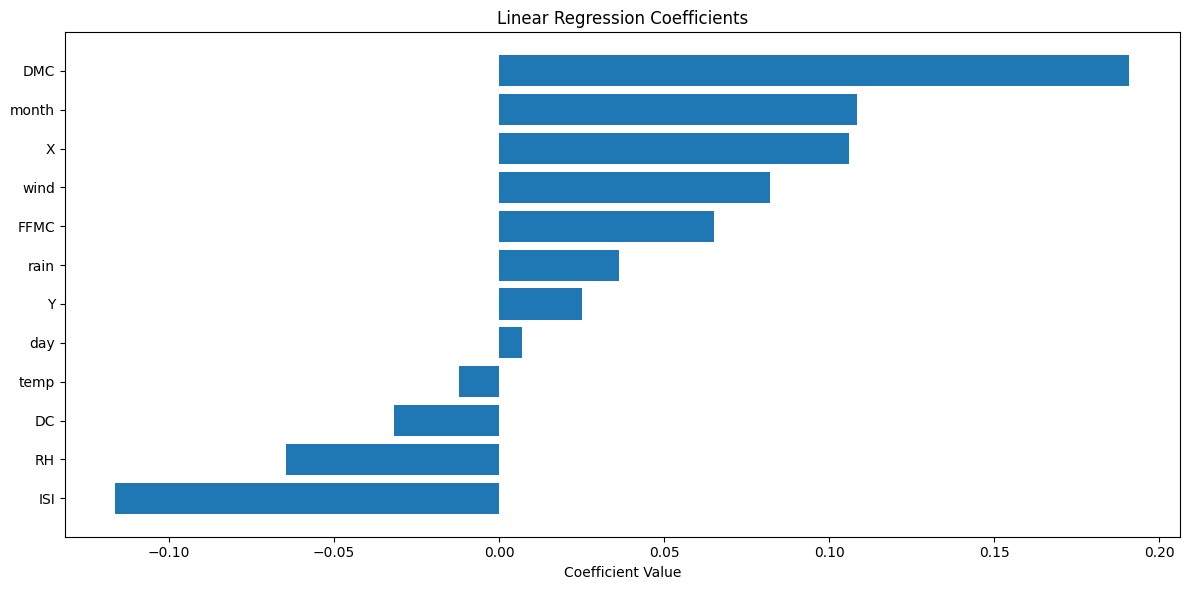

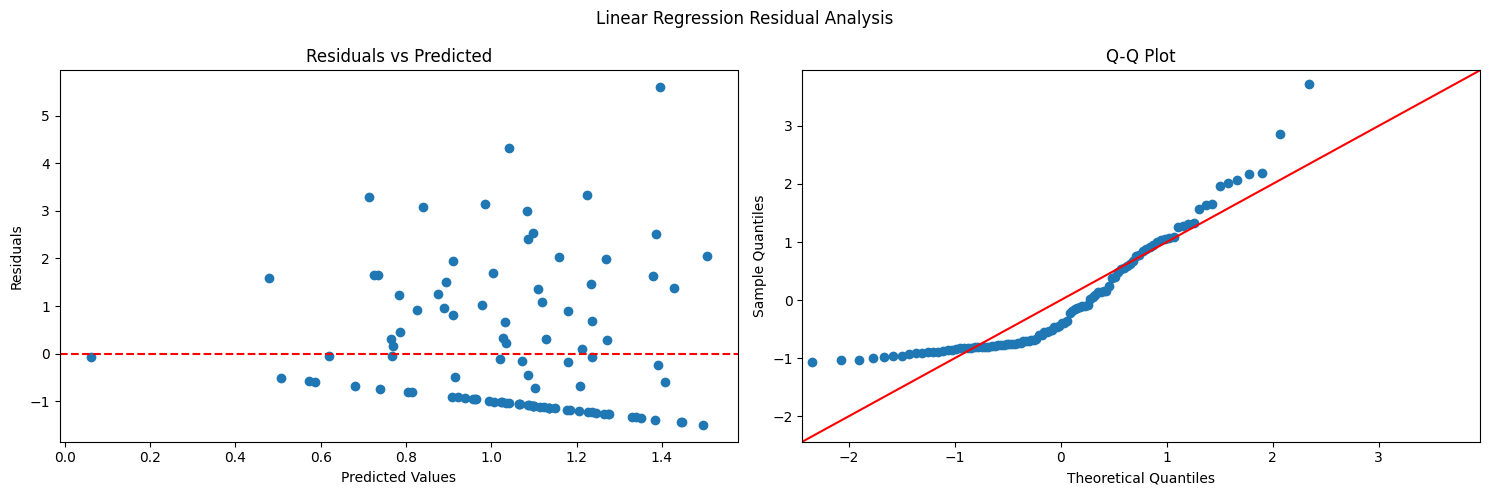

In [21]:
# Linear Regression
best_linear = analyze_model(LinearRegression(), {}, "Linear Regression")

>   The coefficient values indicate the direction and strength of each feature's impact on the target variable, with positive coefficients indicating a positive relationship and negative coefficients indicating a negative relationship.

-   In this plot, DMC (Duff Moisture Code), month, and X have the highest positive coefficients, meaning increases in these variables are associated with an increase in the target variable.
-   ISI (Initial Spread Index) has the largest negative coefficient, suggesting that as ISI increases, the target variable decreases.
-   The plot shows a somewhat random scatter around zero, which is good, but there is a slight pattern in the residuals, indicating potential issues with the model fit.
-   Most points fall near the line in the center of the plot, indicating approximate normality for a majority of residuals.

### Lasso


Lasso Regression Results:
Best parameters: {'alpha': np.float64(0.18420699693267165)}
Training R²: 0.0000
Test R²: -0.0006
Training RMSE: 1.3746
Test RMSE: 1.4830


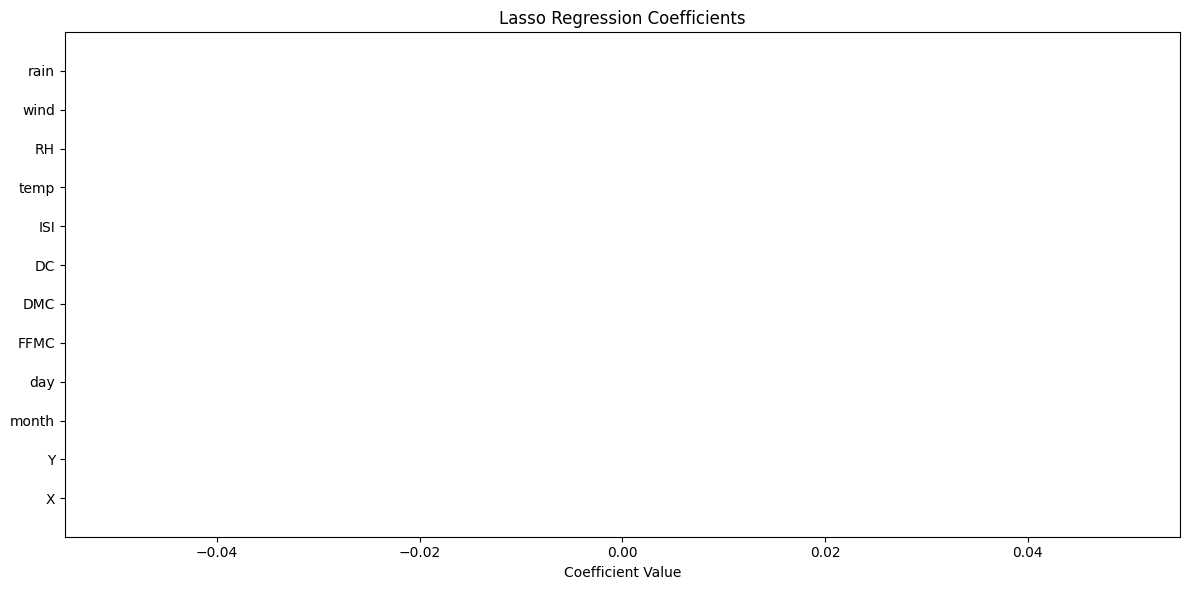

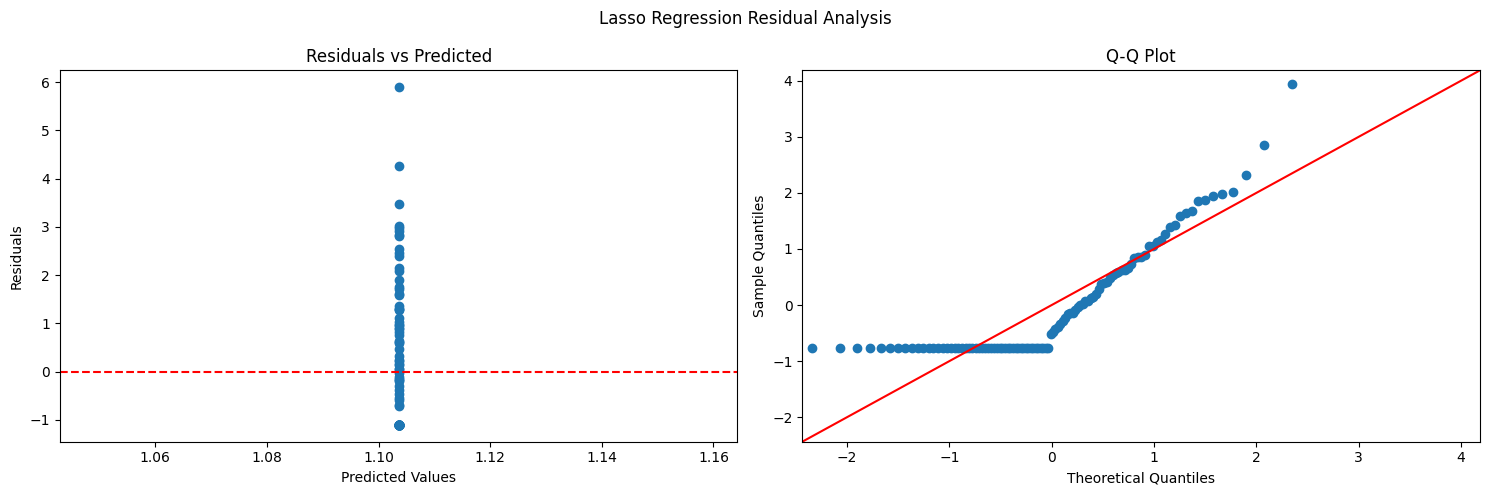

In [22]:
# Lasso Regression
lasso_params = {'alpha': np.logspace(-4, 1, 50)}
best_lasso = analyze_model(Lasso(), lasso_params, "Lasso Regression")

-   In this plot, almost all residuals are concentrated at a single predicted value near 1.10, suggesting that the Lasso model is underfitting the data or predicting nearly the same output value across different inputs.
-   In this Q-Q plot, most residuals deviate from the line, particularly at the extremes. The points initially lie close to the line but quickly diverge as they move toward higher values, indicating that the residuals are not normally distributed.

### Ridge


Ridge Regression Results:
Best parameters: {'alpha': np.float64(10.0)}
Training R²: 0.0298
Test R²: -0.0018
Training RMSE: 1.3540
Test RMSE: 1.4838


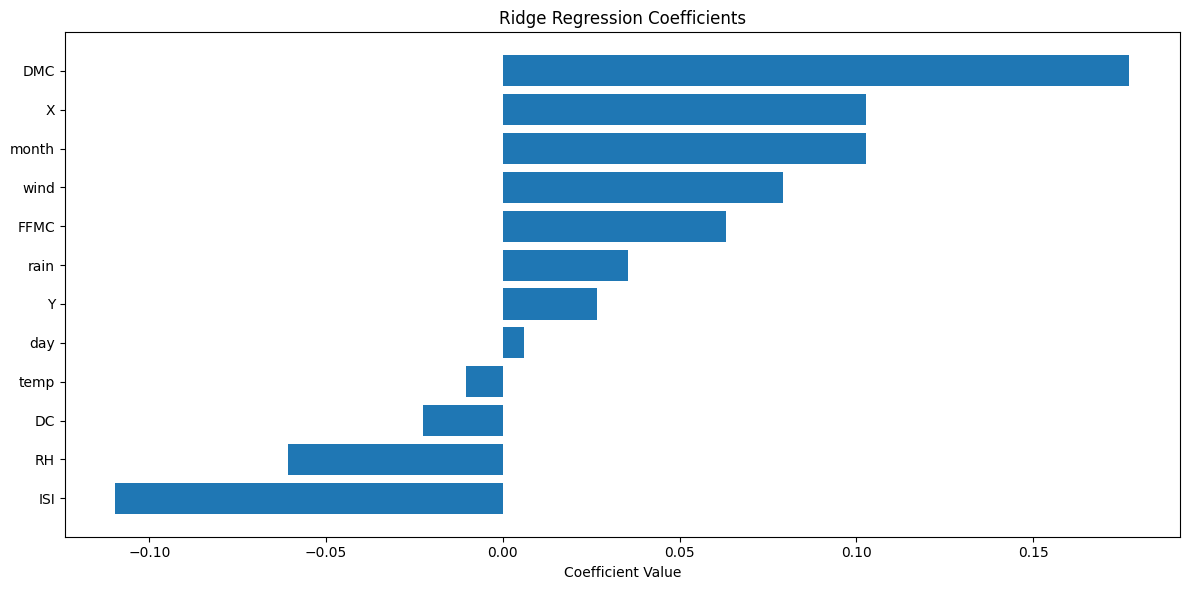

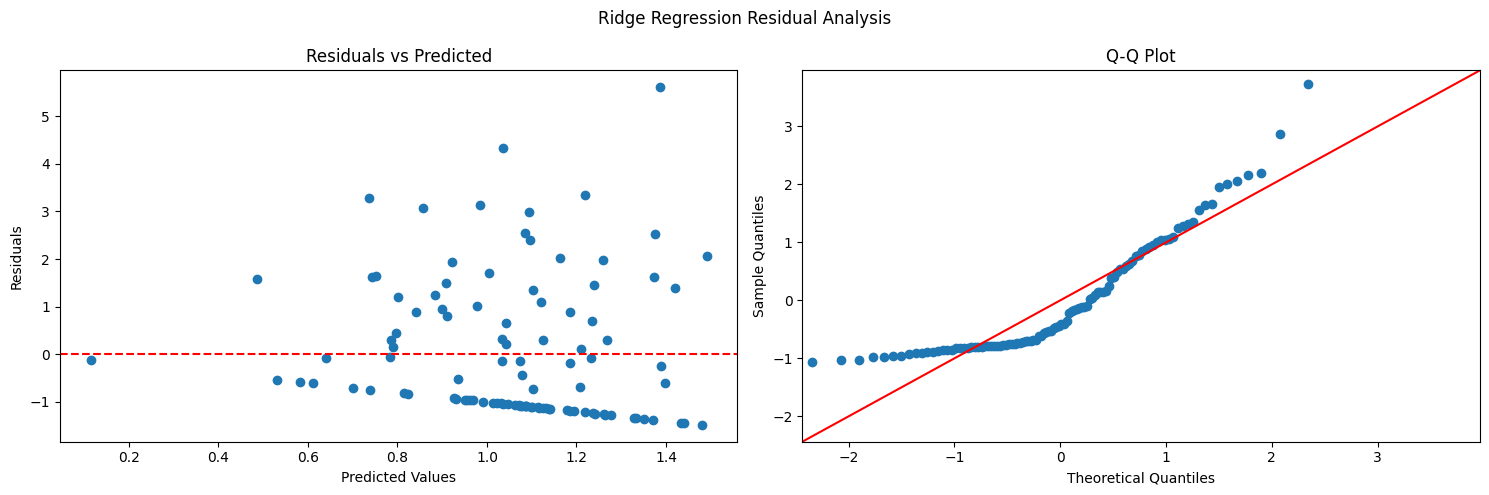

In [23]:
# Ridge Regression
ridge_params = {'alpha': np.logspace(-4, 1, 50)}
best_ridge = analyze_model(Ridge(), ridge_params, "Ridge Regression")

**Same Interpretation as Linear Regression**

### ElasticNet


ElasticNet Regression Results:
Best parameters: {'alpha': np.float64(0.26366508987303583), 'l1_ratio': np.float64(0.7000000000000001)}
Training R²: 0.0000
Test R²: -0.0006
Training RMSE: 1.3746
Test RMSE: 1.4830


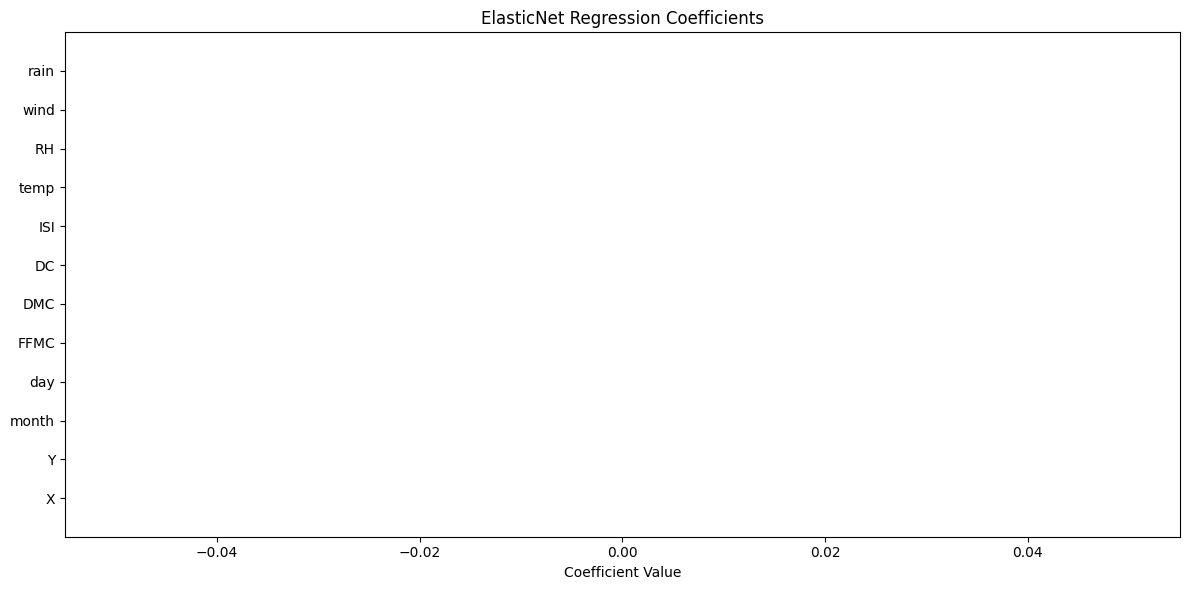

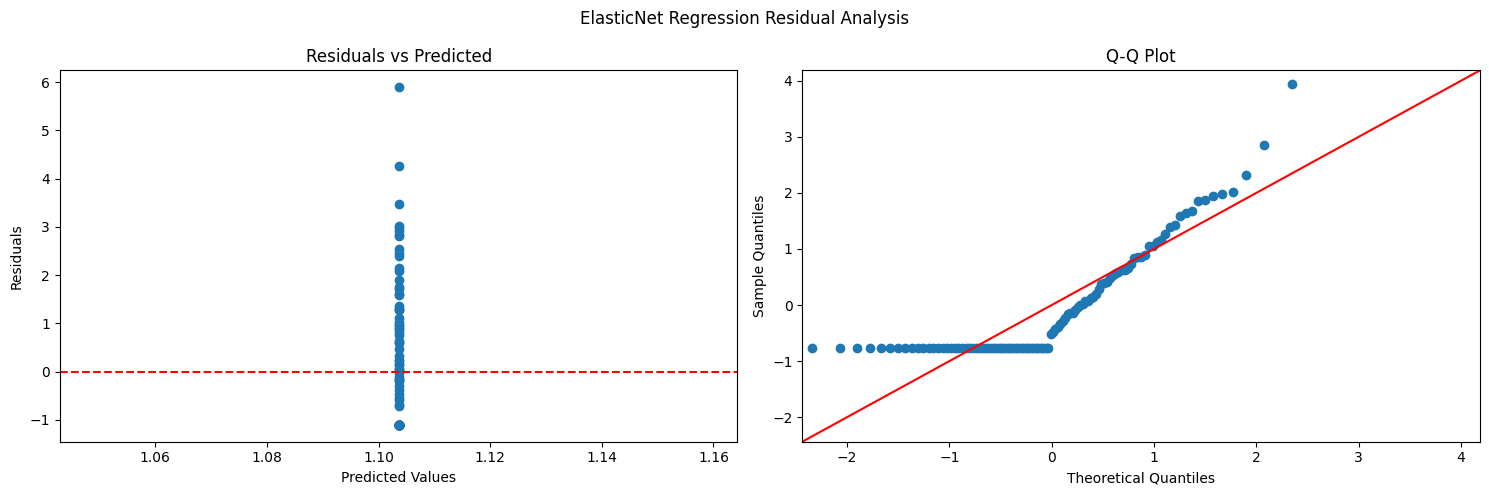

In [24]:
# ElasticNet Regression
elasticnet_params = {
    'alpha': np.logspace(-4, 1, 20),
    'l1_ratio': np.linspace(0.1, 0.9, 9)
}
best_elasticnet = analyze_model(ElasticNet(), elasticnet_params, "ElasticNet Regression")

In [25]:
models = {
    'Linear': best_linear,
    'Lasso': best_lasso,
    'Ridge': best_ridge,
    'ElasticNet': best_elasticnet
}


# Initialize KFold with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform 5-Fold Cross Validation using cross_val_score()
print("5-Fold Cross Validation using cross_val_score()")
for name, model in models.items():
    mse_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-mse_scores)
    mean_rmse = np.mean(rmse_scores)
    std_rmse = np.std(rmse_scores)
    print(f'{name} - Mean RMSE: {mean_rmse:.4f}, Std RMSE: {std_rmse:.4f}')

# Perform 5-Fold Cross Validation using cross_val_predict()
print("\n5-Fold Cross Validation using cross_val_predict()")
for name, model in models.items():
    y_pred = cross_val_predict(model, X, y, cv=kf)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    print(f'{name} - RMSE: {rmse:.4f}')

# Evaluate the results
print("\nEvaluation of Models")
for name, model in models.items():
    model.fit(X, y)
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    print(f'{name} - RMSE on Training Data: {rmse:.4f}')

# Print VIF scores
print("Variance Inflation Factors:")
print(calculate_vif(X))
print("\n" + "="*50 + "\n")

# 1. StatsModels Analysis
print("StatsModels Analysis")
print("-"*50)

# OLS Regression
X_train_sm = sm.add_constant(X_train)
model_sm = sm.OLS(y_train, X_train_sm).fit()
print(model_sm.summary())

# 2. Scikit-learn Analysis
print("\nScikit-learn Analysis")
print("-"*50)

5-Fold Cross Validation using cross_val_score()
Linear - Mean RMSE: 1.4320, Std RMSE: 0.1129
Lasso - Mean RMSE: 1.3940, Std RMSE: 0.1048
Ridge - Mean RMSE: 1.4220, Std RMSE: 0.1049
ElasticNet - Mean RMSE: 1.3940, Std RMSE: 0.1048

5-Fold Cross Validation using cross_val_predict()
Linear - RMSE: 1.4364
Lasso - RMSE: 1.3980
Ridge - RMSE: 1.4259
ElasticNet - RMSE: 1.3980

Evaluation of Models
Linear - RMSE on Training Data: 1.3774
Lasso - RMSE on Training Data: 1.3971
Ridge - RMSE on Training Data: 1.3775
ElasticNet - RMSE on Training Data: 1.3971
Variance Inflation Factors:
   Feature       VIF
6       DC  2.769188
8     temp  2.766729
5      DMC  2.715938
9       RH  1.960343
4     FFMC  1.711713
7      ISI  1.609213
2    month  1.468514
1        Y  1.448213
0        X  1.434815
10    wind  1.155924
3      day  1.059148
11    rain  1.050768


StatsModels Analysis
--------------------------------------------------
                            OLS Regression Results                        

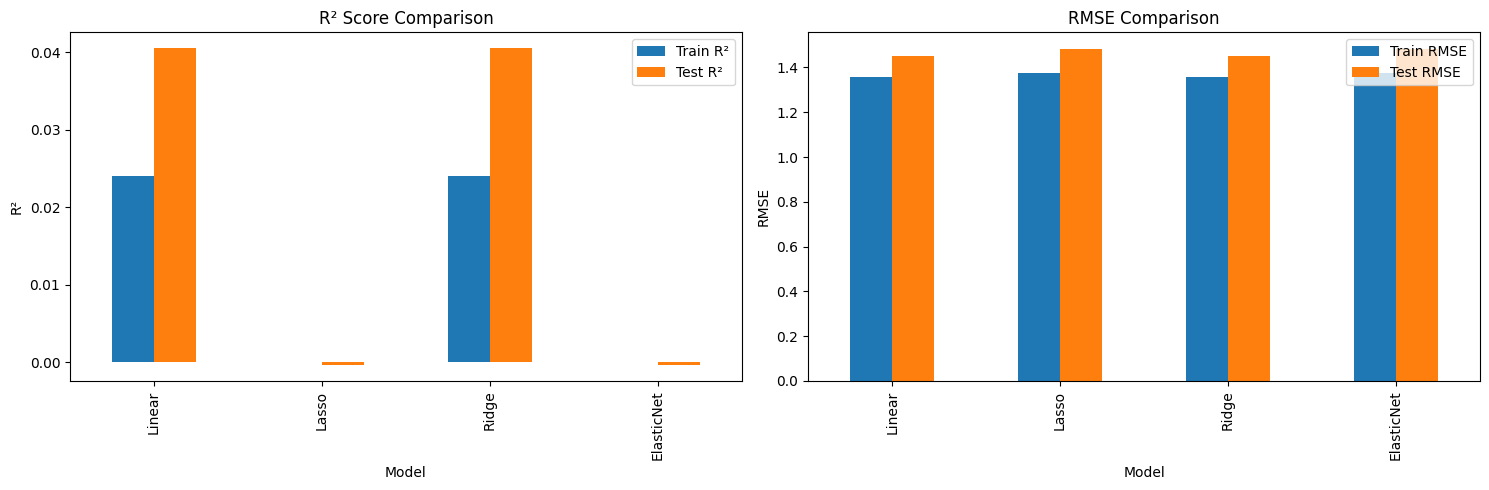


Model Comparison Summary:
     Model  Train R²   Test R²  Train RMSE  Test RMSE
    Linear  0.024089  0.040554    1.357975   1.452146
     Lasso -0.000029 -0.000396    1.374653   1.482812
     Ridge  0.024062  0.040552    1.357994   1.452148
ElasticNet -0.000029 -0.000396    1.374653   1.482812


In [26]:
# Compare models

def plot_model_comparison():
    models = {
        'Linear': best_linear,
        'Lasso': best_lasso,
        'Ridge': best_ridge,
        'ElasticNet': best_elasticnet
    }

    # Prepare comparison data
    comparison_data = []
    for name, model in models.items():
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        
        comparison_data.append({
            'Model': name,
            'Train R²': r2_score(y_train, train_pred),
            'Test R²': r2_score(y_test, test_pred),
            'Train RMSE': np.sqrt(mean_squared_error(y_train, train_pred)),
            'Test RMSE': np.sqrt(mean_squared_error(y_test, test_pred))
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Plot comparison
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # R² comparison
    comparison_df.plot(x='Model', y=['Train R²', 'Test R²'], kind='bar', ax=axes[0])
    axes[0].set_title('R² Score Comparison')
    axes[0].set_ylabel('R²')
    
    # RMSE comparison
    comparison_df.plot(x='Model', y=['Train RMSE', 'Test RMSE'], kind='bar', ax=axes[1])
    axes[1].set_title('RMSE Comparison')
    axes[1].set_ylabel('RMSE')
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df

# Plot model comparison
comparison_results = plot_model_comparison()
print("\nModel Comparison Summary:")
print(comparison_results.to_string(index=False))